In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"

In [7]:

df = pd.read_csv("/content/drive/MyDrive/SGP 6/Year 2009-2010.csv", encoding='latin1')
print(df.head())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2009 7:45   6.95      13085.0  United Kingdom  
1  12/1/2009 7:45   6.75      13085.0  United Kingdom  
2  12/1/2009 7:45   6.75      13085.0  United Kingdom  
3  12/1/2009 7:45   2.10      13085.0  United Kingdom  
4  12/1/2009 7:45   1.25      13085.0  United Kingdom  


In [11]:
print(df.columns)


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [12]:
import pandas as pd
import datetime as dt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/SGP 6/Year 2009-2010.csv", encoding='latin1')

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate RFM metrics
today_date = dt.datetime(2010, 12, 11)  # Assuming analysis date as 11th December 2010
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'Price': 'sum'  # Monetary Value
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

print(rfm.head())


             Recency  Frequency  Monetary
Customer ID                              
12346.0           67         15    578.36
12347.0            3          2    162.95
12348.0           74          1     14.39
12349.0           43          4    899.49
12351.0           11          1     49.46


In [13]:
# Define quantiles for recency, frequency, and monetary values
quantiles = rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])

# Function to assign recency score
def recency_score(x):
    if x <= quantiles['Recency'][0.2]:
        return 5
    elif x <= quantiles['Recency'][0.4]:
        return 4
    elif x <= quantiles['Recency'][0.6]:
        return 3
    elif x <= quantiles['Recency'][0.8]:
        return 2
    else:
        return 1

# Function to assign frequency and monetary scores
def fm_score(x, metric):
    if x <= quantiles[metric][0.2]:
        return 1
    elif x <= quantiles[metric][0.4]:
        return 2
    elif x <= quantiles[metric][0.6]:
        return 3
    elif x <= quantiles[metric][0.8]:
        return 4
    else:
        return 5

# Calculate recency, frequency, and monetary scores
rfm['R_Score'] = rfm['Recency'].apply(recency_score)
rfm['F_Score'] = rfm['Frequency'].apply(fm_score, metric='Frequency')
rfm['M_Score'] = rfm['Monetary'].apply(fm_score, metric='Monetary')

print(rfm.head())


             Recency  Frequency  Monetary  R_Score  F_Score  M_Score
Customer ID                                                         
12346.0           67         15    578.36        3        5        5
12347.0            3          2    162.95        5        2        3
12348.0           74          1     14.39        2        1        1
12349.0           43          4    899.49        3        3        5
12351.0           11          1     49.46        5        1        2


In [14]:
# Function to create RFM segments
def create_segments(row):
    if row['R_Score'] <= 3 and row['F_Score'] <= 3 and row['M_Score'] <= 3:
        return 'Low-Value'
    elif (row['R_Score'] <= 3 and row['F_Score'] > 3 and row['M_Score'] > 3) or \
         (row['R_Score'] > 3 and row['F_Score'] <= 3 and row['M_Score'] > 3) or \
         (row['R_Score'] > 3 and row['F_Score'] > 3 and row['M_Score'] <= 3):
        return 'Mid-Value'
    else:
        return 'High-Value'

# Apply function to create RFM segments
rfm['RFM_Segment'] = rfm.apply(create_segments, axis=1)

print(rfm.head())


             Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
Customer ID                                                            
12346.0           67         15    578.36        3        5        5   
12347.0            3          2    162.95        5        2        3   
12348.0           74          1     14.39        2        1        1   
12349.0           43          4    899.49        3        3        5   
12351.0           11          1     49.46        5        1        2   

            RFM_Segment  
Customer ID              
12346.0       Mid-Value  
12347.0      High-Value  
12348.0       Low-Value  
12349.0      High-Value  
12351.0      High-Value  


In [15]:
# Define the number of segments
num_segments = 3

# Segment the RFM scores using pd.qcut()
rfm['R_Segment'] = pd.qcut(rfm['R_Score'], q=num_segments, labels=False)
rfm['F_Segment'] = pd.qcut(rfm['F_Score'], q=num_segments, labels=False)
rfm['M_Segment'] = pd.qcut(rfm['M_Score'], q=num_segments, labels=False)

# Combine the segments to create RFM segments
rfm['RFM_Segment'] = rfm['R_Segment'].astype(str) + rfm['F_Segment'].astype(str) + rfm['M_Segment'].astype(str)

# Map RFM segments to descriptive labels
segment_labels = {
    '000': 'Low-Value',
    '100': 'Mid-Value',
    '110': 'Mid-Value',
    '111': 'High-Value',
    '010': 'Low-Value',
    '001': 'Low-Value',
    '101': 'Mid-Value',
    '011': 'Mid-Value'
}
rfm['RFM_Segment'] = rfm['RFM_Segment'].map(segment_labels)

print(rfm.head())


             Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
Customer ID                                                            
12346.0           67         15    578.36        3        5        5   
12347.0            3          2    162.95        5        2        3   
12348.0           74          1     14.39        2        1        1   
12349.0           43          4    899.49        3        3        5   
12351.0           11          1     49.46        5        1        2   

            RFM_Segment  R_Segment  F_Segment  M_Segment  
Customer ID                                               
12346.0             NaN          1          2          2  
12347.0             NaN          2          0          1  
12348.0       Low-Value          0          0          0  
12349.0             NaN          1          1          2  
12351.0             NaN          2          0          0  


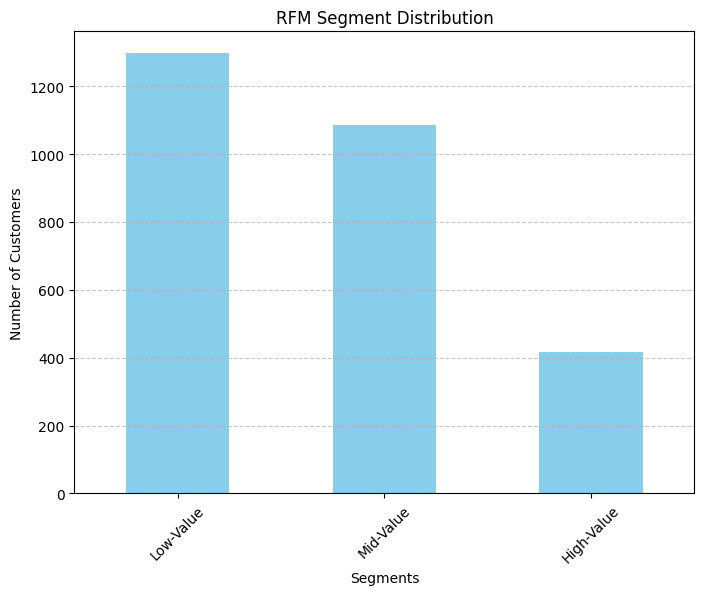

In [16]:
import matplotlib.pyplot as plt

# Count the number of customers in each segment
segment_distribution = rfm['RFM_Segment'].value_counts()

# Plot the segment distribution
plt.figure(figsize=(8, 6))
segment_distribution.plot(kind='bar', color='skyblue')
plt.title('RFM Segment Distribution')
plt.xlabel('Segments')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [24]:
# Define function to create RFM customer segments
def create_rfm_segments(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 4 and row['M_Score'] >= 4:
        return "Can't Lose"
    else:
        return 'Lost'

# Apply function to create RFM segments
rfm['RFM_Customer_Segment'] = rfm.apply(create_rfm_segments, axis=1)

# Analyze the distribution of RFM customer segments
customer_segment_distribution = rfm['RFM_Customer_Segment'].value_counts()

print(customer_segment_distribution)


Lost                   2964
Champions               816
Potential Loyalists     365
Can't Lose              238
Name: RFM_Customer_Segment, dtype: int64


In [30]:
import plotly.express as px

# Define function to create value segments
def create_value_segments(row):
    if row['M_Score'] <= 3:
        return 'Low-Value'
    elif row['M_Score'] <= 4:
        return 'Mid-Value'
    else:
        return 'High-Value'

# Apply function to create value segments
rfm['Value Segment'] = rfm.apply(create_value_segments, axis=1)

# Analyze the distribution of customers across different RFM customer segments within each value segment
segment_product_counts = rfm.groupby(['Value Segment', 'RFM_Customer_Segment']).size().reset_index(name='Count')
segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

# Plot the treemap
fig_treemap_segment_product = px.treemap(segment_product_counts,
                                         path=['Value Segment', 'RFM_Customer_Segment'],
                                         values='Count',
                                         color='Value Segment', color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show()


In [32]:
# Filter the data to include only the customers in the Champions segment
champions_segment = rfm[rfm['RFM_Customer_Segment'] == 'Champions']

# Create a box plot for each RFM score within the Champions segment
fig = go.Figure()
fig.add_trace(go.Box(y=champions_segment['R_Score'], name='Recency'))
fig.add_trace(go.Box(y=champions_segment['F_Score'], name='Frequency'))
fig.add_trace(go.Box(y=champions_segment['M_Score'], name='Monetary'))

# Update layout
fig.update_layout(title='Distribution of RFM Values within Champions Segment',
                  yaxis_title='RFM Value',
                  showlegend=True)

# Show plot
fig.show()


In [33]:
# Calculate the correlation matrix within the champions segment
correlation_matrix = rfm[rfm['RFM_Customer_Segment'] == 'Champions'][['R_Score', 'F_Score', 'M_Score']].corr()

# Visualize the correlation matrix using a heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.columns,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation')))

fig_heatmap.update_layout(title='Correlation Matrix of RFM Values within Champions Segment')

fig_heatmap.show()


In [34]:
import plotly.graph_objects as go

pastel_colors = px.colors.qualitative.Pastel

# Get the counts of customers in each RFM segment
segment_counts = rfm['RFM_Customer_Segment'].value_counts()

# Create a bar chart to compare segment counts
fig = go.Figure(data=[go.Bar(x=segment_counts.index, y=segment_counts.values,
                             marker=dict(color=pastel_colors))])

# Set the color of the Champions segment as a different color
champions_color = 'rgb(158, 202, 225)'
fig.update_traces(marker_color=[champions_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                  marker_line_color='rgb(8, 48, 107)',
                  marker_line_width=1.5, opacity=0.6)

# Update the layout
fig.update_layout(title='Comparison of RFM Segments',
                  xaxis_title='RFM Segments',
                  yaxis_title='Number of Customers',
                  showlegend=False)

fig.show()


In [35]:
import plotly.graph_objects as go

# Calculate the average Recency, Frequency, and Monetary scores for each segment
segment_scores = rfm.groupby('RFM_Customer_Segment')['R_Score', 'F_Score', 'M_Score'].mean().reset_index()

# Create a grouped bar chart to compare segment scores
fig = go.Figure()

# Add bars for Recency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM_Customer_Segment'],
    y=segment_scores['R_Score'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'
))

# Add bars for Frequency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM_Customer_Segment'],
    y=segment_scores['F_Score'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'
))

# Add bars for Monetary score
fig.add_trace(go.Bar(
    x=segment_scores['RFM_Customer_Segment'],
    y=segment_scores['M_Score'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'
))

# Update the layout
fig.update_layout(
    title='Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)

fig.show()


<ipython-input-35-068d4a6962a3>:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

